## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [3]:
X.isnull().sum() # везде 0 => NaN'ов в таблице нет

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [4]:
X.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

заметим, что все переменные принимают вещественные значнения => являются количественными

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [5]:
from sklearn.model_selection import train_test_split

np.random.seed(211)
X_train_all, X_test_all, y_train, y_test  = train_test_split(X, y, test_size=0.3, shuffle=True)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [7]:
X_train = X_train_all[['alcohol', 'magnesium']]
X_test = X_test_all[['alcohol', 'magnesium']]

In [8]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

In [9]:
classifiers = []
for k in [1, 3, 5, 10, 15, 25]:
  classifiers.append(KNeighborsClassifier(k).fit(X_train, y_train))

In [10]:
accuracy = []
for clf in classifiers:
  accuracy.append([clf.get_params()['n_neighbors'], np.mean(clf.predict(X_train) == y_train), np.mean(clf.predict(X_test) == y_test)])

accuracy_df = pd.DataFrame(data=accuracy, columns=['NN', 'Train', 'Test'])
accuracy_df

,NN,Train,Test
0,1,0.991935,0.629630
1,3,0.879032,0.611111
2,5,0.798387,0.648148
3,10,0.814516,0.666667
4,15,0.790323,0.629630
5,25,0.741935,0.685185


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [11]:
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [12]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

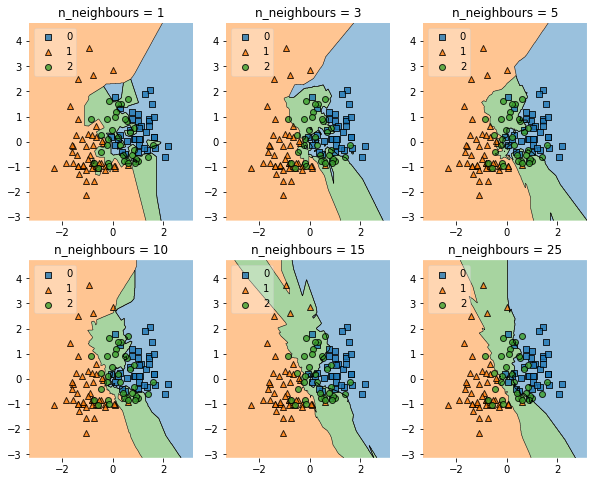

In [13]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(10,8))

labels = [f"n_neighbours = {clf.get_params()['n_neighbors']}" for clf in classifiers]
for clf, lab, grd in zip(classifiers, labels, itertools.product([0, 1], [0, 1, 2])):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

In [14]:
pd.DataFrame(y).value_counts()

1    71
0    59
2    48
dtype: int64

Заметим, что классы распределены более-менее равномерно => можно не ждать подвохов при рассмотрении доли правильных ответов

**Результаты задания 1.3**:
* Логично, что самая высокая доля на train'е при k=1 (при этом оно не равно 1, т.к. видимо есть какие-то объекты, отличающиеся друг от друга только целевой переменной и они портят все). При этом доля правильных ответов на test'е одна из самых маленьких (модель переобучена)
* Большая разность долей правильных ответов на train'е и на test'е при k=3 намекает на возможное переобучение   
* Наиболее привлекательно здесь выглядит k=25: самый высокий результат на test'е и наименьшая разность между train'ом и test'ом (т.е. устойчивость к измненению выборки)   

**Результаты задания 1.5**:
* наиболее линейной и адекватной выглядит решающая поверхность при k=25 (другие имеют более сложную структуры, слишком отвлекаясь на шумовые объекты)



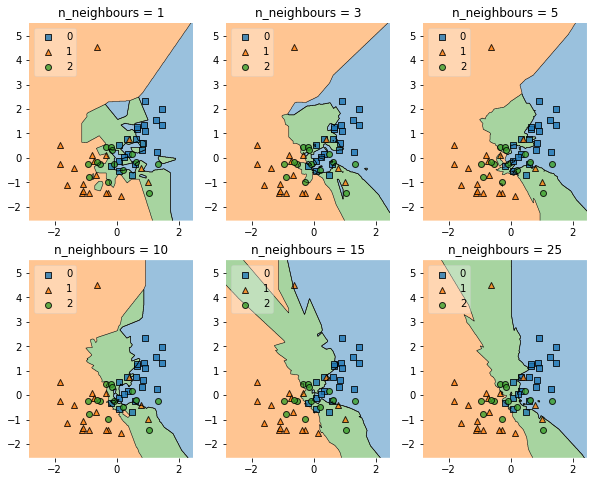

In [15]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(10,8))

labels = [f"n_neighbours = {clf.get_params()['n_neighbors']}" for clf in classifiers]
for clf, lab, grd in zip(classifiers, labels, itertools.product([0, 1], [0, 1, 2])):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_test, y=y_test, clf=clf, legend=2)
    plt.title(lab)

plt.show()

Для выбора оптимального k построим также решающие поверхности для test'а.
Ситуация здесь аналогична заданию 1.5 и наиболее привлкательно выглядит k=25

Исходя из всего сказанного выше, сделаем вывод, что *k=25 - оптимальный выбор*

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

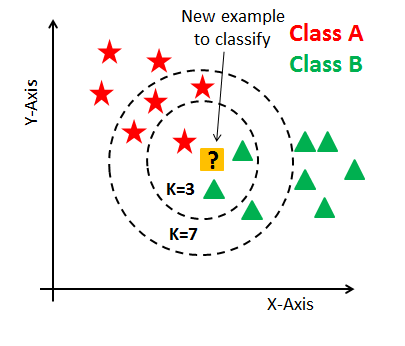

In [16]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k
    
    def fit(self, X, y):
      self.X = X
      self.y = y
      pass
    
    def predict(self, X):
      y_pred = []
      for obj in X:
        n = np.hstack((self.y.reshape((-1, 1)), np.sqrt(np.sum(np.square(self.X - obj), axis=1)).reshape((-1, 1))))
        y_pred.append(Counter(n[n[:, 1].argsort()][:self.k, 0]).most_common(1)[0][0])        
      return np.array(y_pred)

In [17]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [18]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [77]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [78]:
data.isnull().sum() # везде 0 => NaN'ов в таблице нет

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

Исходя из описания набора данных, заметим, что depth =  z/mean(x, y) => этот признак не несет дополнительной информации. Признак 'Unnamed: 0' также бесполезен, т.к. это просто индексы. Поэтому удалим их.

In [79]:
data = data.drop(columns=["Unnamed: 0","depth"])

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [80]:
data.corr()

,carat,table,price,x,y,z
carat,1.000000,0.181618,0.921591,0.975094,0.951722,0.953387
table,0.181618,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.150929,0.861249,0.970772,0.952006,1.000000


Все признаки (кроме table) имеют высокую корредяцию с целевой переменной. Самую большую - carat

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [81]:
data = pd.get_dummies(data, drop_first=True)

**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [82]:
np.random.seed(211)
X_train, X_test, y_train, y_test  = train_test_split(data.drop(columns=["price"]), data.price, test_size=0.3, shuffle=True)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [83]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linReg = LinearRegression()
linReg.fit(X_train, y_train)
print(f'На тренировочной выборке: {mean_squared_error(y_train, linReg.predict(X_train))}')
print(f'На тестовой выборке: {mean_squared_error(y_test, linReg.predict(X_test))}')

На тренировочной выборке: 1266223.7171258193
На тестовой выборке: 1318850.6297927068


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [85]:
linReg.coef_

array([ 5351.82198598,   -17.85836103, -1061.22918132,    30.08648706,
        -148.88885098,   189.46862995,   487.33524958,   393.87145012,
         360.9812594 ,   -76.48729455,  -101.16767594,  -199.15245822,
        -356.62478024,  -445.06323505,  -521.09246944,   953.81197249,
        1534.08973695,   989.31389713,  1618.3530222 ,  1755.00949796,
        1229.44207289,  1427.47903582])

In [100]:
x = pd.DataFrame(data = data.drop(columns=["price"]).columns, columns=['feature'])
x['coef_simple'] = [np.abs(int(val)) for val in linReg.coef_]
x.sort_values(by='coef_simple', ascending=False)

,feature,coef_simple
0,carat,5351
19,clarity_VS2,1755
18,clarity_VS1,1618
16,clarity_SI1,1534
21,clarity_VVS2,1427
20,clarity_VVS1,1229
2,x,1061
17,clarity_SI2,989
15,clarity_IF,953
14,color_J,521


Видим, что:
* признаки 'carat', 'clarity_VS1', 'clarity_VS2', clarity_SI1', 'clarity_VVS1', 'clarity_VVS2' и 'x' имеют веса 4-го порядка
* признаки 'z', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI2' имеют вес 3-го порядка              
* признаки 'color_E', 'y', 'table' имеют вес 2-го порядка

Т.е. признаки с наибольшими весами (хотя бы на порядок большими всех остальных) - 'carat', 'clarity_VS1', 'clarity_VS2', clarity_SI1', 'clarity_VVS1', 'clarity_VVS2' и 'x' 

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [87]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [88]:
lassoLinReg = Lasso(10)
lassoLinReg.fit(X_train, y_train)

lassoLinReg.coef_

array([4852.32415349,  -26.39431895, -580.85117231,   -0.        ,
       -144.43493178,   68.10384126,  287.02401289,  212.1127959 ,
        193.98273589,   -6.81993707,  -34.68204006, -122.04396304,
       -284.48100853, -372.30917369, -462.48435879,  645.16842473,
        813.33704957,  360.2920528 , 1007.78094325, 1050.14146188,
        806.34689289,  931.99360914])

В данном случае 8 весов стали на порядок меньше. При этом все еще сохранятся сильный разброс порядоков весов (от 1 до 4) 

In [89]:
ridgeLinReg = Ridge(10)
ridgeLinReg.fit(X_train, y_train)

ridgeLinReg.coef_

array([ 5314.16067879,   -18.70852768, -1022.10717752,    27.09639795,
        -149.3563917 ,   189.26814178,   486.30827763,   393.14306054,
         360.70525489,   -76.14471631,  -101.00376187,  -198.59070279,
        -355.72634172,  -443.67949602,  -519.80945195,   941.91534069,
        1505.12068646,   964.47754698,  1594.05009117,  1726.8395237 ,
        1212.99279641,  1407.95939413])

В данном случае порядки весов вообще не изменились

Исходя из весов Lasso и Ridge, можно сделать вывод, что проблема мультиколлинеарности в изначальной регрессии проявлялась минимально 

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

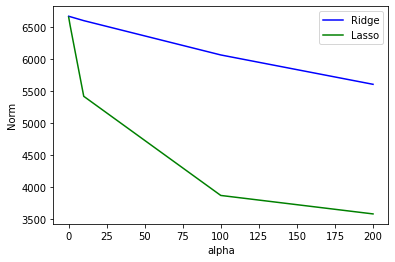

In [110]:
alpha = [0.1, 1, 10, 100, 200]
normLasso = []
normRidge = []
for a in alpha:
  lassoLinReg = Lasso(a)
  lassoLinReg.fit(X_train, y_train)
  normLasso.append(np.linalg.norm(lassoLinReg.coef_))
  ridgeLinReg = Ridge(a)
  ridgeLinReg.fit(X_train, y_train)
  normRidge.append(np.linalg.norm(ridgeLinReg.coef_))

plt.plot(alpha, normRidge, 'b')
plt.plot(alpha, normLasso, 'g')
plt.ylabel('Norm')
plt.xlabel('alpha')
plt.legend(labels = {'Ridge', 'Lasso'}, loc='best')
plt.show()

Lasso гораздо агрессивнее уменьшает веса, как видно из графика 

Lasso-регрессию часто используют для отбора признаков, т.к. она зануляет некоторые веса, тем самым обозначая ненужные признаки

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [112]:
from sklearn.linear_model import LassoCV

lassoCV = LassoCV(alphas = [0.1, 1, 10, 100, 200], cv=5)
lassoCV.fit(X_train, y_train)
print(lassoCV.alphas_)
print(np.mean(lassoCV.mse_path_, axis=1))

[2.e+02 1.e+02 1.e+01 1.e+00 1.e-01]
[2141011.89691928 1772621.61340128 1334143.3785401  1276359.98645665
 1276903.46863651]


Наибольшее качество при $\alpha$ = 1

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [101]:
lasso_final = Lasso(1)
lasso_final.fit(X_train, y_train)

x['coef_lasso'] = [int(val) for val in lasso_final.coef_]
x['coef_simple'] = [int(val) for val in linReg.coef_]
x

,feature,coef_simple,coef_lasso
0,carat,5351,5301
1,table,-17,-18
2,x,-1061,-993
3,y,30,3
4,z,-148,-145
5,cut_Good,189,177
6,cut_Ideal,487,468
7,cut_Premium,393,376
8,cut_Very Good,360,345
9,color_E,-76,-69


Заметим, что применение Lasso-регрессии практически не изменило начальные веса признаков (лишь вес для 'y' уменьшился ровно в 10 раз), что говорит о том, что начальная регрессия подобрала веса достаточно точно.

Заметим, что важнейшим признаком для формирования цены бриллианта является его вес ('carat') (собственно в жизни это так и работает).
Большие веса также имеют некоторые степени прозрачности камня (видимо, самые крутые). Может предположить, что прозрачность алмаза считается показателем его качества.
Большой по модулю (но отрицательный) вес у 'x'. Получается, что длинный алмаз - не круто (может его в украшения трудно инкрустировать). 

Веса уровеня огранки влияют уже меньше (видимо, огранка ценится меньше, чем степень прозрачности). При этом чем лучше огранка, тем больше вес.

Все признаки цвета имеют отрицательный вес. Возможно, что какой-нибудь 'бесцветный' алмаз считается самым натуральным и поэтому больше всего ценится, а цветные мол хуже. При этом некоторые цвета имеют весьма маленький вес (как и 'z') => они не особо информативны.

У 'y' и 'table' веса очень маленькие => они наименее информативны.

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [93]:
print(f'Lasso-регрессия: {mean_squared_error(y_test, lasso_final.predict(X_test))}')
print(f'Обычная регрессия: {mean_squared_error(y_test, linReg.predict(X_test))}')

Lasso-регрессия: 1319914.1659134994
Обычная регрессия: 1318850.6297927068


Благодаря применению регуляризации Lasso-регрессия оказалась немного лучше (скомпесировала большие веса). Использовать для предсказаний стоит именно ее.